In [152]:
import numpy as np 
from numpy import array
import pandas as pd 
from sklearn import datasets
import statistics
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics

# Setosa, Versicolour, and Virginica
# 0, 1 or 2
iris = datasets.load_iris()





In [153]:

def fit(X, y):
    # Get the amount of different features e.g, 4
    nrOfFeatures = np.size(X, axis=1)
    # Make y shape == X shape
    yReshaped = np.reshape(y, (np.size(y), 1))
    # Append label to each featurevector
    dataset = np.append(X, yReshaped, axis=1)
    # Find the labels e.g [1, 0]
    classes = list(set(y))
    classes.sort(reverse=True)
    # Separate the classes into positives and negatives
    # Where 1 represent the positive class and vice versa
    filterPositiveFeatureVectors = dataset[:, -1] == classes[0]
    filterNegativeFeatureVectors = dataset[:, -1] == classes[1]
    positiveFeatureVectors = dataset[filterPositiveFeatureVectors]
    negativeFeatureVectors = dataset[filterNegativeFeatureVectors] 
    # Slicing away the labels
    posFeatureMatrix = positiveFeatureVectors[:, : -1]
    negFeatureMatrix = negativeFeatureVectors[:, : -1]
    # Transposing the matrix to sort the same kind of feature in the same vectors
    # [f0:[1,5,9,13,17,19,21,23,25], f1:[2,6,10,14,18,20,22,24], ...]
    posFeatureMatrixTransposed = np.transpose(posFeatureMatrix)
    negFeatureMatrixTransposed = np.transpose(negFeatureMatrix)
    # Calculating the normal distribution on all feature vectors
    # Placing them in two separate distribution lists
    # I am using Gaussian Naive Bayes because it is the simplest. I only need to calculate standard deviation and the average for each feature.
    # I also use Gaussian, because I am working with continous data types
    posDistrList = list(map(statistics.NormalDist.from_samples, posFeatureMatrixTransposed))
    negDistrList = list(map(statistics.NormalDist.from_samples, negFeatureMatrixTransposed))

    return posDistrList, negDistrList



In [155]:
# Bayes theorem to calculate probabilty with the trained distributions. 
# Using pdf as refered to Probability density function from the normal distributions.
# As instructed in https://docs.python.org/3/library/statistics.html at the bottom.
# Skipping the evidence P(data) factor, because it is just a constant over all the factors which is redundant.
def calculatePosterior(featureVector, distrList, prior):
    posterior = prior
    for feature, distrObj in zip(featureVector, distrList):
        posterior *= distrObj.pdf(feature)
    return posterior

# returns [[negProb, posProb], [negProb, posProb], [negProb, posProb]...]
# newDataMatrix: [[5.2, 4.1, 1.5, 0.1], [5.2, 4.1, 1.5, 0.1] ...]
# posDistr: [obj, obj, obj, obj]
def predictMatrix(newDataMatrix, posDistrList, negDistrList):
    posProbVector = np.array([])
    negProbVector = np.array([])
    for vector in newDataMatrix:
        posPosterior = calculatePosterior(vector, posDistrList, 0.5)
        negPosterior = calculatePosterior(vector, negDistrList, 0.5)
        posProbVector = np.append(posProbVector, posPosterior)
        negProbVector = np.append(negProbVector, negPosterior)
    probaMatrix = np.stack((negProbVector, posProbVector), axis=1)
    return probaMatrix

In [156]:
# scoreMatrix: [[score, y], [score, y] ...100]
def calculateTprFpr(scoreMatrix):
    # extract truths (y)
    scoreVector = scoreMatrix[:, 0]
    # extract score
    truthVector = scoreMatrix[:, -1]
    maxScore = max(scoreVector)
    minScore = min(scoreVector)
    thresholdLow = np.arange(minScore, 1.0, (1.0-minScore)/50.0)
    thresholdHigh = np.arange(1.0, maxScore, (maxScore-1.0)/50.0)
    thresholdVector = np.append(thresholdLow, thresholdHigh)
    tprVector = np.array([])
    fprVector = np.array([])

    for threshold in thresholdVector:
        true_positive = np.greater_equal(scoreVector, threshold) & np.equal(truthVector, 1) # predicted class 1, actual class 1
        true_negative = np.less_equal(scoreVector, threshold) & np.equal(truthVector, 0) # predicted class 0, actual class 0
        false_positive = np.greater_equal(scoreVector, threshold) & np.equal(truthVector, 0) # predicted class 1, actual class 0
        false_negative = np.less_equal(scoreVector, threshold) & np.equal(truthVector, 1) # predicted class 0, actual class 1
        tpr = np.round(np.divide(true_positive.sum(), (true_positive.sum() + false_negative.sum())), 5)
        if(np.isnan(tpr)):
            tpr = 0
        fpr = np.round(np.divide(false_positive.sum(), (false_positive.sum() + true_negative.sum())), 5)
        if(np.isnan(fpr)):
            fpr = 0   
        tprVector = np.append(tprVector, tpr)
        fprVector = np.append(fprVector, fpr)

    return tprVector, fprVector

In [157]:
def drawROC(tprVector, fprVector):
    areaUnderCurve = metrics.auc(fprVector, tprVector)
    plt.plot(fprVector, tprVector, label='ROC curve (area = %.2f)' %areaUnderCurve)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend()
    plt.show()

In [158]:
# Only accepts y inputs as either 0 for representing negative class or 1 for representing positive class
def trainTestCrossValidation(X, y):
    k = 10
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    partitions = 10
    sns.set()
    scoreMegaVector = np.array([])

    for train_i, test_i in kf.split(X):
        X_train = X[train_i, :]
        y_train = y[train_i]
        X_test = X[test_i, : ]
        y_test = y[test_i]
        # Training the iris dataset, where normal distributions are calculated.
        posDistrList, negDistrList = fit( X_train, y_train)
        # Predicts class: returns [[negProb, posProb], [negProb, posProb], [negProb, posProb] ...10]
        probaMatrix = predictMatrix(X_test, posDistrList, negDistrList)
        # Score = pos proba / neg proba
        # score: [score1, score2, score3...10]
        score = np.apply_along_axis(lambda probaVector: probaVector[1]/probaVector[0], 1, probaMatrix)
        # Append truthvalue to each score
        # scoreTruthMatrix: [[score, y], [score, y], ...10]
        scoreTruthMatrix = np.stack((score, y_test), axis=1)
        scoreMegaVector = np.append(scoreMegaVector, scoreTruthMatrix)
        
    # reshape megaVector to Matrix: [[score, y], [score, y] ...100]
    scoreMegaMatrix = scoreMegaVector.reshape(-1, 2)
    tprVector, fprVector = calculateTprFpr(scoreMegaMatrix)
    # print roc curve
    drawROC(tprVector, fprVector)
    



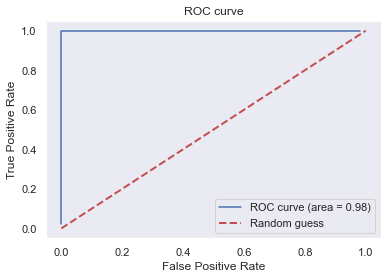

In [159]:
# Cross validation with 10 folds on Setosa and Versicolour flower only
X = iris.data[:100, :]  # taking all 4 attributes within Setosa and Versicolour flower only
y = iris.target[ : 100] # taking only the Setosa and Versicolour flowers
trainTestCrossValidation(X, y)

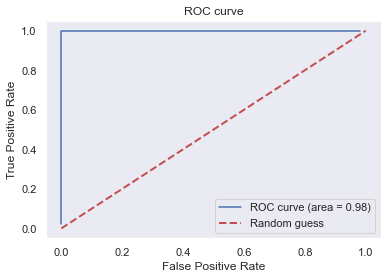

In [160]:
# Cross validation with 10 folds on Setosa and Virginica flower only
X1 = iris.data[:50, :]  
X2 = iris.data[100:150, :]
X = np.concatenate((X1, X2), axis=0)
y1 = iris.target[ : 50] 
y2 = iris.target[ 100:150]
y = np.concatenate((y1, y2))
y = np.where(y == 2, 1, y)
trainTestCrossValidation(X, y)

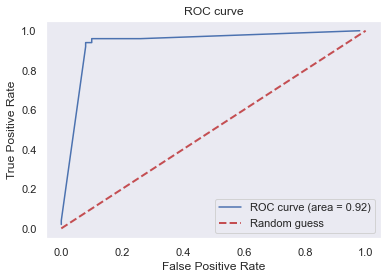

In [161]:
# Cross validation with 10 folds on Versicolour and Virginica flower only
X = iris.data[50:150, :]
y = iris.target[ 50: 150] 
y = np.where(y == 1, 0, y)
y = np.where(y == 2, 1, y)

trainTestCrossValidation(X, y)